In [50]:
import numpy as np
from data_cube_analysis import getdata, rms, masks, moments
from astropy import units as u 
from astropy.io import fits
import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')

# # Download these from my github 
# import getdata # https://github.com/ashleythomasbarnes/data_cube_analysis/blob/master/getdata.py
# import moments # https://github.com/ashleythomasbarnes/data_cube_analysis/blob/master/moments.py
# import rms # https://github.com/ashleythomasbarnes/data_cube_analysis/blob/master/rms.py
# import masks # https://github.com/ashleythomasbarnes/data_cube_analysis/blob/master/masks.py

In [19]:
def get_moms(inputfile, velo=np.array([-200,200]), rmsvelo=[[-300,-200],[200,300]], hthresh=5, lthresh=2):
    '''
    This function computes the moments (integrated properties) of spectral line data from a FITS cube.
    
    Args:
    inputfile (str): Path to the input FITS file.
    velo (np.array): Array representing velocity bounds for the calculation of moments. Default is [-200,200].
    rmsvelo (list): List of two lists, each representing a pair of velocity bounds for the calculation of root mean square (RMS). Default is [[-300,-200],[200,300]].
    hthresh (float): High threshold value for the mask. Default is 5.
    lthresh (float): Low threshold value for the mask. Default is 2.
    
    Returns:
    tuple: Tuple containing the original header-data unit (HDU), the data cube, the RMS map, and the moment maps.
    '''

    # Use the get_cube function from the getdata module to extract the data cube from the FITS file.
    cube = getdata.get_cube(inputfile)

    # Use the get_rms function from the rms module to compute the RMS map of the cube over the specified velocity range.
    rms_map = rms.get_rms(cube, rmsvelo)
    
    # Use the get_expmask function from the masks module to generate a mask for the cube using the specified thresholds and the RMS map.
    mask = masks.get_expmask(cube, rms_map, hthresh=hthresh, lthresh=lthresh)
    
    # Apply the mask to the cube.
    cube_masked = cube.with_mask(mask)
    
    # Use the get_momentmaps function from the moments module to compute moment maps of the masked cube over the specified velocity range.
    moms = moments.get_momentmaps(cube_masked, rms_map, velo)
   
    # Define the output file name by removing '.fits' from the input file name.
    outputfile = inputfile.replace('.fits', '')
    
    # Write the zeroth moment map (integrated intensity) to a FITS file.
    moms['mom0'].writeto('%s_mom.fits' %outputfile, overwrite=True)
    
    # Write the maximum intensity map to a FITS file.
    moms['max'].writeto('%s_max.fits' %outputfile, overwrite=True)
    
    # Write the signal-to-noise ratio map of the zeroth moment to a FITS file.
    moms['mom0s2n'].writeto('%s_mom0s2n.fits' %outputfile, overwrite=True)
    
    # Return the original HDU, the data cube, the RMS map, and the moment maps.
    return(cube, rms_map, moms)

In [32]:
def get_channel_maps(inputfile, start=-200, stop=200, step=20):
    """
    This function calculates the zeroth moment (total intensity) for each velocity channel in a data cube,
    and writes the results to a FITS file.

    Args:
    inputfile (str): Path to the input FITS file.
    cube (SpectralCube): The data cube from which the channel maps are to be extracted.
    start (int): The start of the velocity range for channel extraction. Default is -200 km/s.
    stop (int): The end of the velocity range for channel extraction. Default is 200 km/s.
    step (int): The velocity step size for channel extraction. Default is 20 km/s.

    Returns:
    None
    """

    # Use the get_cube function from the getdata module to extract the data cube from the FITS file.
    cube = getdata.get_cube(inputfile)
    
    # Define the velocity channels.
    channels = np.arange(start, stop, step) *u.km/u.s

    # Get the number of channels.
    n = len(channels)-1

    # Initialize an array to hold the channel map data.
    channelmaps_data = ['']*(n)

    # For each channel...
    for i in range(n): 

        # ...extract the cube for that channel...
        cube_channels = cube.spectral_slab(channels[i], channels[i+1])

        # ...and calculate the zeroth moment, storing the result in the array.
        channelmaps_data[i] = cube_channels.moment0().hdu.data

    # Get the FITS header from the last cube's zeroth moment.
    channelmaps_header = cube_channels.moment0().hdu.header

    # Create a FITS HDU using the channel map data and the header.
    channelmaps_hdu = fits.PrimaryHDU(channelmaps_data, channelmaps_header)

    # Define the output file name by removing '.fits' from the input file name.
    outputfile = inputfile.replace('.fits', '')

    # Write the HDU to a FITS file.
    channelmaps_hdu.writeto('%s_chans.fits' %outputfile, overwrite=True)

    return(channelmaps_hdu)

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import aplpy
from math import ceil

def plot_channel_maps(channelmaps_hdu, outputfile=None, start=-200, stop=200, step=20):
    """
    This function plots all the channel maps contained in a FITS HDU in a grid with a specified number of columns.
    It shows the velocity range in the upper right corner of each plot.

    Args:
    channelmaps_hdu (HDU): The FITS HDU containing the channel maps.
    start (int): The start of the velocity range for channel extraction. Default is -200 km/s.
    stop (int): The end of the velocity range for channel extraction. Default is 200 km/s.
    step (int): The velocity step size for channel extraction. Default is 20 km/s.

    Returns:
    None
    """
    # Determine the number of channels from the FITS HDU.
    channels = channelmaps_hdu.header['NAXIS3']

    # Determine the number of rows needed for the plot grid.
    rows = ceil(channels / 4)  # 4 is the number of columns.

    # Initialize the plot figure.
    fig = plt.figure(figsize=(20,10))

    # For each channel...
    for chan in range(channels):
        
        # ...create a copy of the FITS HDU...
        channelmaps_hdu_ = channelmaps_hdu.copy()
        
        # ...replace the data in the HDU with the data for the current channel...
        channelmaps_hdu_.data = channelmaps_hdu_.data[chan]
        
        # ...create a subplot in the appropriate position in the grid...
        gc = aplpy.FITSFigure(channelmaps_hdu_, subplot=(rows, 4, chan+1), figure=fig)  # 4 columns
        
        # ...display the channel map in grayscale and with contours...
        # gc.show_grayscale()
        gc.show_colorscale(cmap='turbo')
        # gc.show_contour(channelmaps_hdu_, levels=5)
        
        # Remove ticks etc
        gc.axis_labels.hide()
        gc.tick_labels.hide()

        # ...and display the velocity range in the upper right corner.
        velo_range = f"{start + chan*step} to {start + (chan+1)*step} km/s"
        gc.add_label(0.95, 0.95, velo_range, relative=True, horizontalalignment='right')
    
    # Adjust the subplot layout to reduce space between subplots
    fig.tight_layout(h_pad=0, w_pad=0)
    # plt.subplots_adjust(wspace=0, hspace=0)
    
    # Save the figure. 
    if outputfile != None: 
        fig.savefig(outputfile, bbox_inches='tight')
    
    return()

()

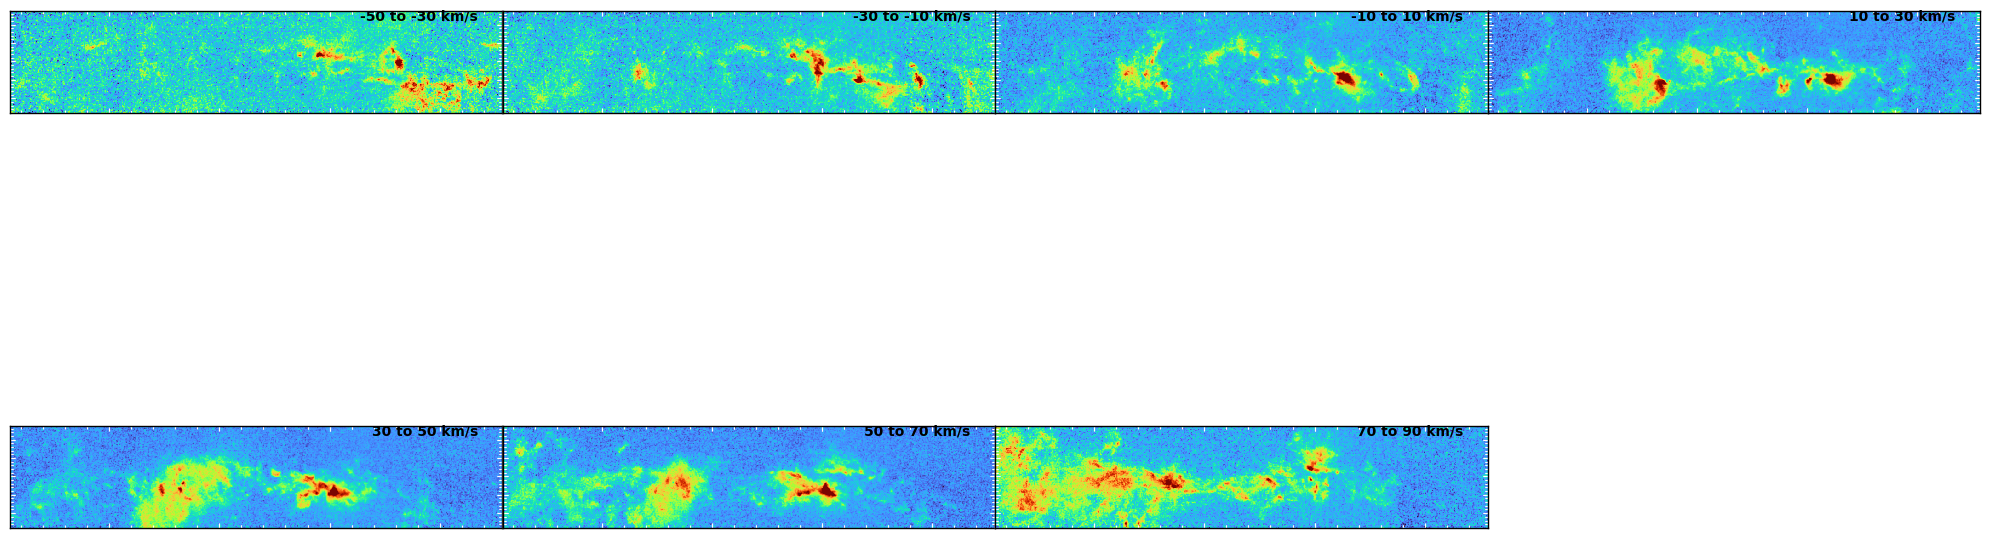

In [60]:
# Define the path of the input FITS file.
# The FITS file contains astronomical data in a format that's widely used in the field.
inputfile = './../../data/45m/CS21.OGEO.SP.NEW.fits'

# The get_moms() function processes the FITS file to compute several parameters.
# cube: This is a 3D data cube from the FITS file, representing spatial and spectral information.
# rms_map: This is a map of the root mean square noise in the cube data.
# moms: These are moment maps computed from the data cube. Moment maps summarize spectral information in the cube.
cube, rms_map, moms = get_moms(inputfile)

# The get_channel_maps() function further processes the data cube to extract channel maps.
# Channel maps are 2D slices of the 3D cube at specific velocity ranges.
# start, stop, step parameters are used to define the velocity ranges for the channel maps.
# In this case, channel maps are generated for velocity ranges from -50 to 100 in steps of 20.
channelmaps_hdu = get_channel_maps(inputfile, start=-50, stop=100, step=20)

# The plot_channel_maps() function takes the channel maps generated by the previous function
# and generates a visual plot. This plot consists of a grid where each panel is a different
# channel map. The velocity range of each map is indicated in the upper right corner of each panel.
plot_channel_maps(channelmaps_hdu, outputfile='CS21.OGEO.SP.NEW.chans.pdf', start=-50, stop=100, step=20)